/home/pbellec/env/psy3018/lib/python3.8/site-packages/nilearn/datasets/__init__.py:86: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "
/home/pbellec/env/psy3018/lib/python3.8/site-packages/numpy/lib/npyio.py:2407: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  output = genfromtxt(fname, **kwargs)


<AxesSubplot:xlabel='MG2', ylabel='Frequency'>

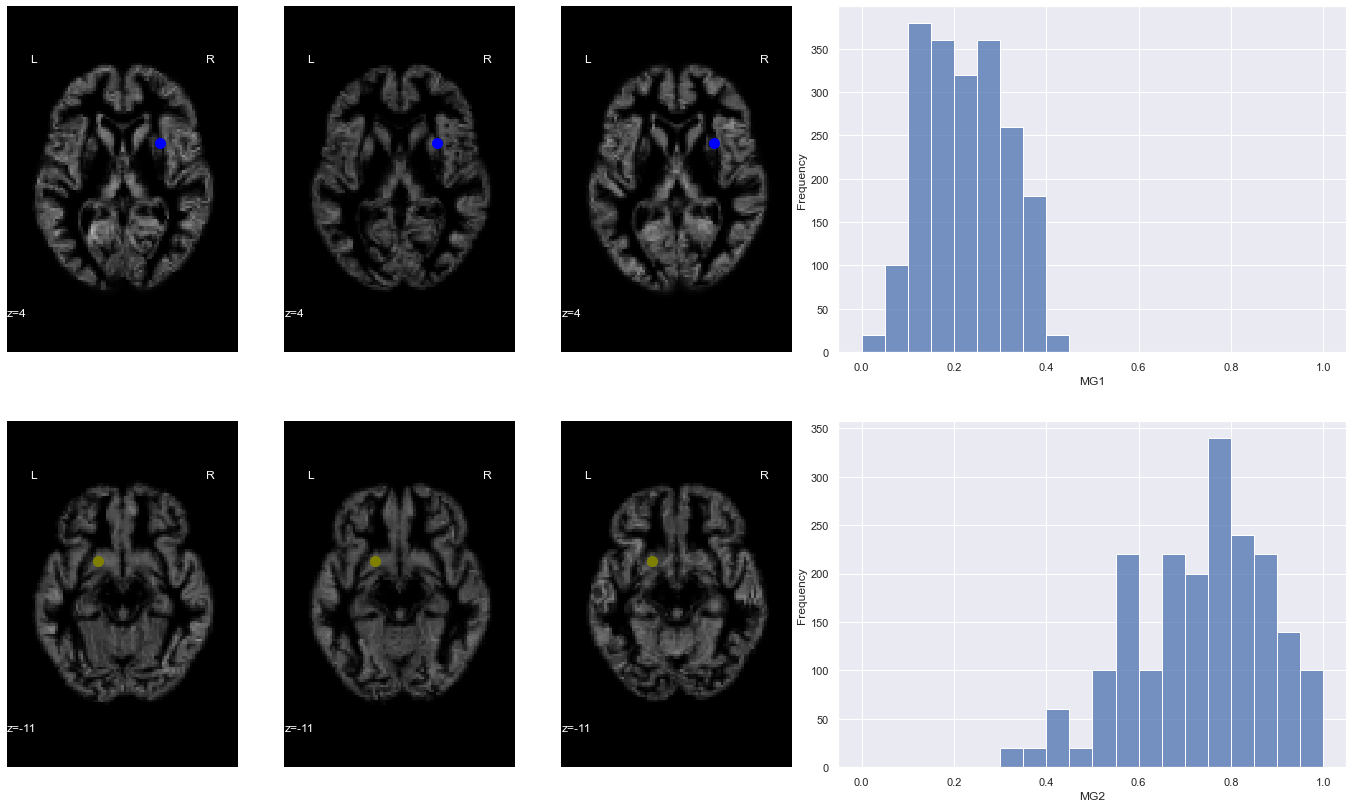

In [1]:
# Importer les librairies
import numpy as np
import matplotlib.pyplot as plt
from nilearn import datasets
from nilearn.input_data import NiftiMasker
from nilearn.image import get_data

# Charge les données
n_subjects = 100  
oasis_dataset = datasets.fetch_oasis_vbm(n_subjects=n_subjects)
gray_matter_map_filenames = oasis_dataset.gray_matter_maps
age = oasis_dataset.ext_vars['age'].astype(float)
sex = oasis_dataset.ext_vars['mf'] == b'F'

# On convertit les données en pandas dataframe
# Deux voxels intéressants ont été sélectionnés
import pandas as pd
coords = np.array([[ 29.,  10.,   4.], [-19.,   8., -11.]])
colors = ['blue', 'olive']

from nilearn import input_data
masker = input_data.NiftiSpheresMasker(coords)
gm = masker.fit_transform(gray_matter_map_filenames)
subject_label = [f'sub-{num}' for num in range(n_subjects)]
df = pd.DataFrame({
    "subject_label": subject_label,
    "age": age,
    "sexe": oasis_dataset.ext_vars['mf'],
    "MG1": gm[:, 0],
    "MG2": gm[:, 1]
    })

df["sexe"] = df["sexe"].replace([b'F', b'M'], value=['femelle', 'male'])

# On génère la Figure
from nilearn import plotting
import seaborn as sns
fig = plt.figure(figsize=(24, 14))

for i in range(0, 6):        
    nx = np.floor_divide(i, 3)
    ny = np.remainder(i, 3)
    ax = plt.subplot2grid((2, 5), (nx, ny), colspan=1)
    roi_img = plotting.plot_anat(
        gray_matter_map_filenames[i], cut_coords=[coords[nx][2]], figure=fig,
        axes=ax, display_mode='z', colorbar=False)
    roi_img.add_markers([coords[nx]], colors[nx], 100)

sns.set_theme(style="darkgrid")
ax = plt.subplot2grid((2, 5), (0, 3), colspan=2)
sns.histplot(
    df["MG1"], ax=ax, binwidth=0.05, binrange=[0, 1], stat='frequency')

ax = plt.subplot2grid((2, 5), (1, 3), colspan=2)
sns.histplot(
    df["MG2"], ax=ax, binwidth=0.05, binrange=[0, 1], stat='frequency')


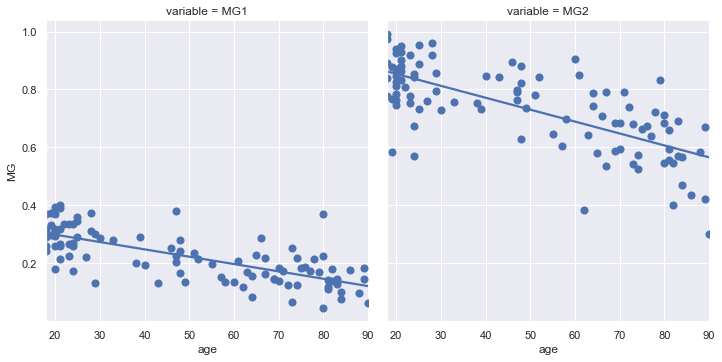

In [2]:
# On réorganise de DataFrame pour utiliser seaborn
df2 = df.melt(id_vars=["age", "sexe"], value_vars=["MG1", "MG2"], value_name="MG")
fig = sns.lmplot(x="age", y="MG", data=df2, col='variable',
           ci=None, scatter_kws={"s": 50, "alpha": 1})

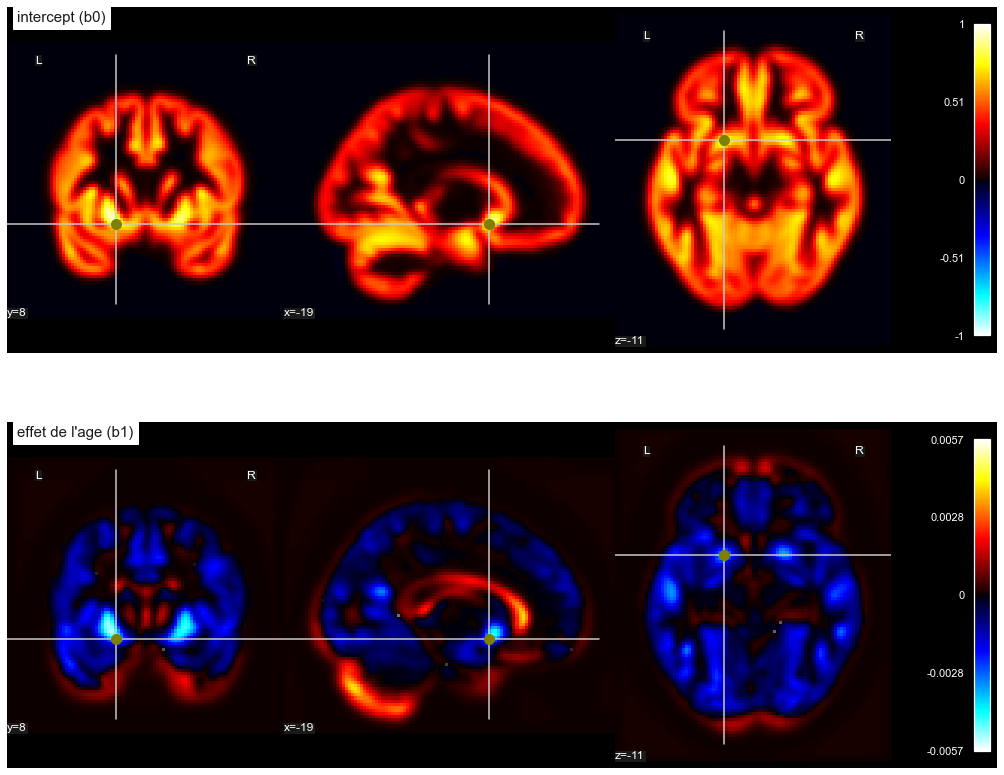

In [4]:
from nilearn.glm.second_level import make_second_level_design_matrix
design_df = df[["subject_label", "age"]].replace(['femelle', 'male'], value=[0, 1])
design_matrix = make_second_level_design_matrix(
    subject_label,
    design_df
    )
from nilearn.glm.second_level import SecondLevelModel
second_level_model = SecondLevelModel(smoothing_fwhm=5.0)
second_level_model = second_level_model.fit(gray_matter_map_filenames,
                                            design_matrix=design_matrix)
beta0 = second_level_model.compute_contrast(second_level_contrast="intercept", output_type="effect_size")
beta1 = second_level_model.compute_contrast(second_level_contrast="age", output_type="effect_size")

# On génère la Figure
from nilearn import plotting
import seaborn as sns
fig = plt.figure(figsize=(24, 14))

ax = plt.subplot2grid((2, 4), (0, 0), colspan=3)
roi_img = plotting.plot_stat_map(
    beta0, bg_img=gray_matter_map_filenames[0], cut_coords=coords[1], figure=fig,
    axes=ax, display_mode='ortho', colorbar=True, title='intercept (b0)')
roi_img.add_markers([coords[1]], colors[1], 100)

ax = plt.subplot2grid((2, 4), (1, 0), colspan=3)
roi_img = plotting.plot_stat_map(
    beta1, bg_img=gray_matter_map_filenames[0], cut_coords=coords[1], figure=fig,
    axes=ax, display_mode='ortho', colorbar=True, title='effet de l\'age (b1)')
roi_img.add_markers([coords[1]], colors[1], 100)


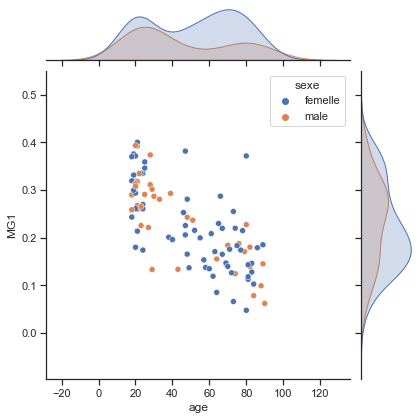

In [7]:
sns.set_theme(style="ticks")

# Show the joint distribution using kernel density estimation
fig = sns.jointplot(
    data=df,
    x="age", y="MG1", hue="sexe",
    kind="scatter",
)

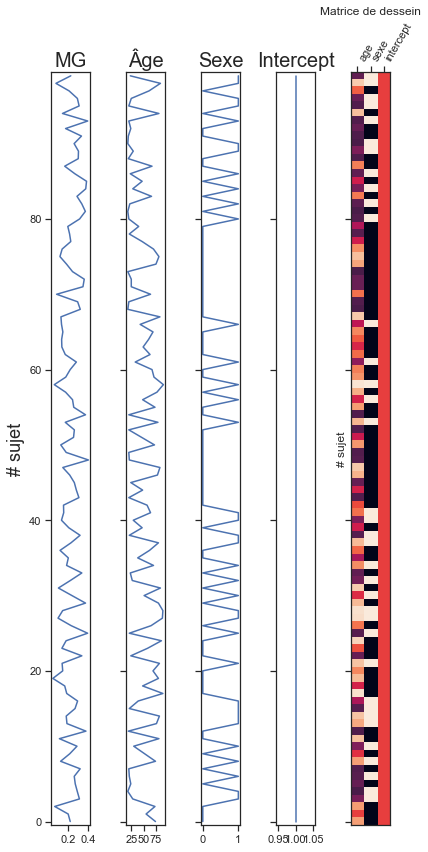

In [30]:
from nilearn.plotting import plot_design_matrix
design_df = df[["subject_label", "age", "sexe"]].replace(['femelle', 'male'], value=[0, 1])
design_matrix = make_second_level_design_matrix(
    subject_label,
    design_df
    )
fig, ax = plt.subplots(ncols=5, figsize=(6, 12), sharey=True)
Y = df["MG1"].to_numpy()
X = design_matrix.to_numpy()
ax[0].plot(np.expand_dims(Y, axis=1), range(len(Y)))
ax[1].plot(X[:,0], range(len(Y)))
ax[2].plot(X[:,1], range(len(Y)))
ax[3].plot(X[:,2], range(len(Y)))
ax[0].set_ylabel('# sujet', fontsize=18)
ax[0].set_title('MG', fontsize=20)
ax[1].set_title('Âge', fontsize=20)
ax[2].set_title('Sexe', fontsize=20)
ax[3].set_title('Intercept', fontsize=20)
plot_design_matrix(design_matrix, ax=ax[4])
ax[4].set_title('Matrice de dessein', fontsize=12)
ax[4].set_ylabel('# sujet')
plt.gca().invert_yaxis()
plt.tight_layout()

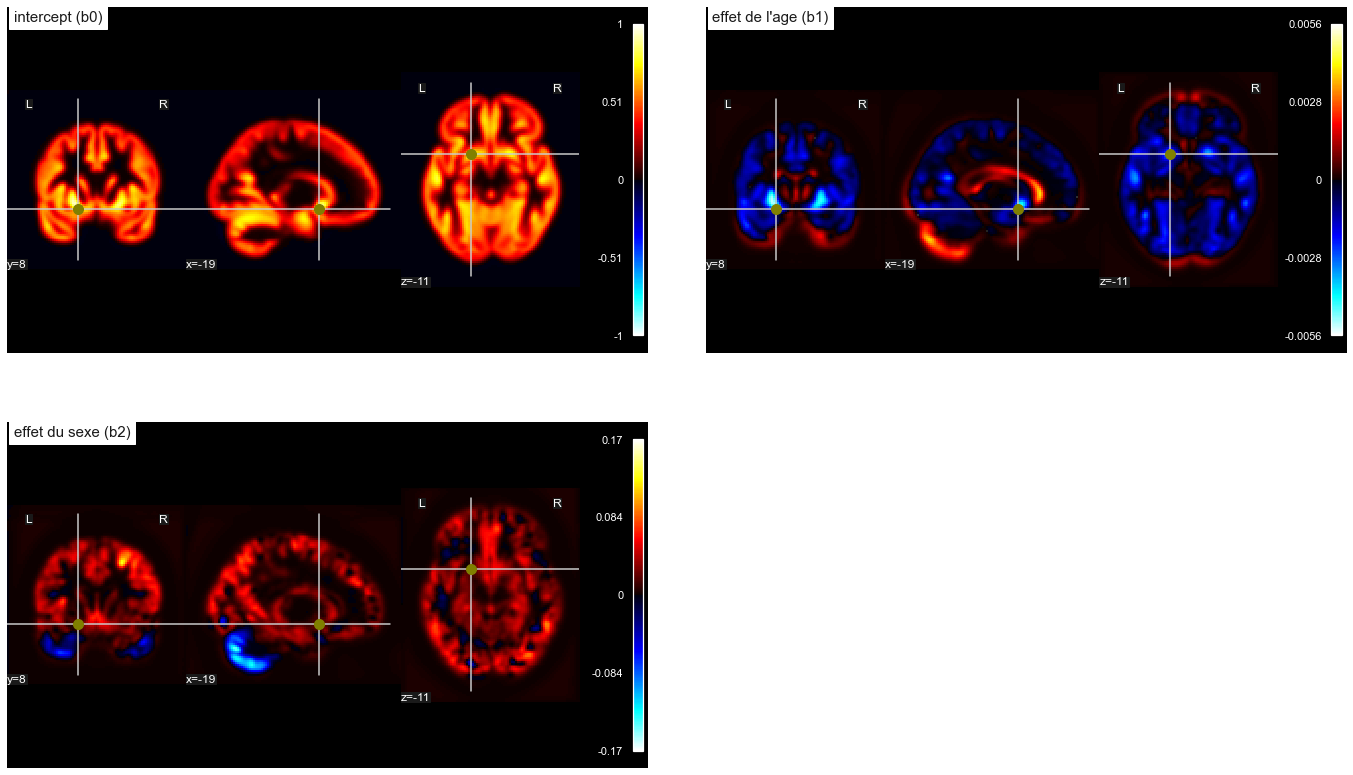

In [31]:
second_level_model = SecondLevelModel(smoothing_fwhm=5.0)
second_level_model = second_level_model.fit(gray_matter_map_filenames,
                                            design_matrix=design_matrix)
beta0 = second_level_model.compute_contrast(second_level_contrast="intercept", output_type="effect_size")
beta1 = second_level_model.compute_contrast(second_level_contrast="age", output_type="effect_size")
beta2 = second_level_model.compute_contrast(second_level_contrast="sexe", output_type="effect_size")

# On génère la Figure
from nilearn import plotting
import seaborn as sns
fig = plt.figure(figsize=(24, 14))

ax = plt.subplot2grid((2, 4), (0, 0), colspan=2)
roi_img = plotting.plot_stat_map(
    beta0, bg_img=gray_matter_map_filenames[0], cut_coords=coords[1], figure=fig,
    axes=ax, display_mode='ortho', colorbar=True, title='intercept (b0)')
roi_img.add_markers([coords[1]], colors[1], 100)

ax = plt.subplot2grid((2, 4), (0, 2), colspan=2)
roi_img = plotting.plot_stat_map(
    beta1, bg_img=gray_matter_map_filenames[0], cut_coords=coords[1], figure=fig,
    axes=ax, display_mode='ortho', colorbar=True, title='effet de l\'age (b1)')
roi_img.add_markers([coords[1]], colors[1], 100)

ax = plt.subplot2grid((2, 4), (1, 0), colspan=2)
roi_img = plotting.plot_stat_map(
    beta2, bg_img=gray_matter_map_filenames[0], cut_coords=coords[1], figure=fig,
    axes=ax, display_mode='ortho', colorbar=True, title='effet du sexe (b2)')
roi_img.add_markers([coords[1]], colors[1], 100)

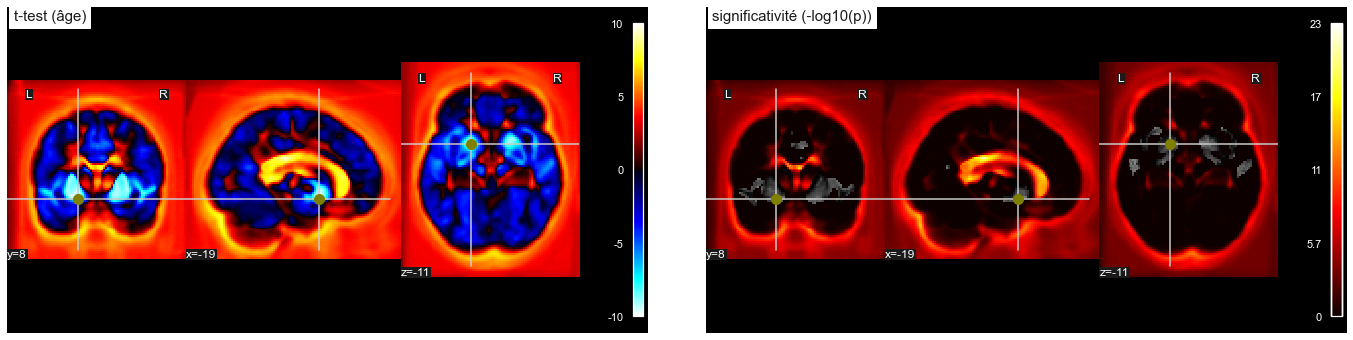

In [39]:
from nilearn.image import math_img
z_score = second_level_model.compute_contrast(second_level_contrast="age", output_type="z_score")
p_value = second_level_model.compute_contrast(second_level_contrast="age", output_type="p_value")
neg_log_pval = math_img("-np.log10(np.minimum(1, img))", img=p_value)

# On génère la Figure
from nilearn import plotting
import seaborn as sns
fig = plt.figure(figsize=(24, 6))

ax = plt.subplot2grid((1, 4), (0, 0), colspan=2)
roi_img = plotting.plot_stat_map(
    z_score, bg_img=gray_matter_map_filenames[0], cut_coords=coords[1], figure=fig,
    axes=ax, display_mode='ortho', colorbar=True, title='t-test (âge)')
roi_img.add_markers([coords[1]], colors[1], 100)

ax = plt.subplot2grid((1, 4), (0, 2), colspan=2)
roi_img = plotting.plot_stat_map(
    neg_log_pval, bg_img=gray_matter_map_filenames[0], cut_coords=coords[1], figure=fig,
    axes=ax, display_mode='ortho', colorbar=True, title='significativité (-log10(p))')
roi_img.add_markers([coords[1]], colors[1], 100)



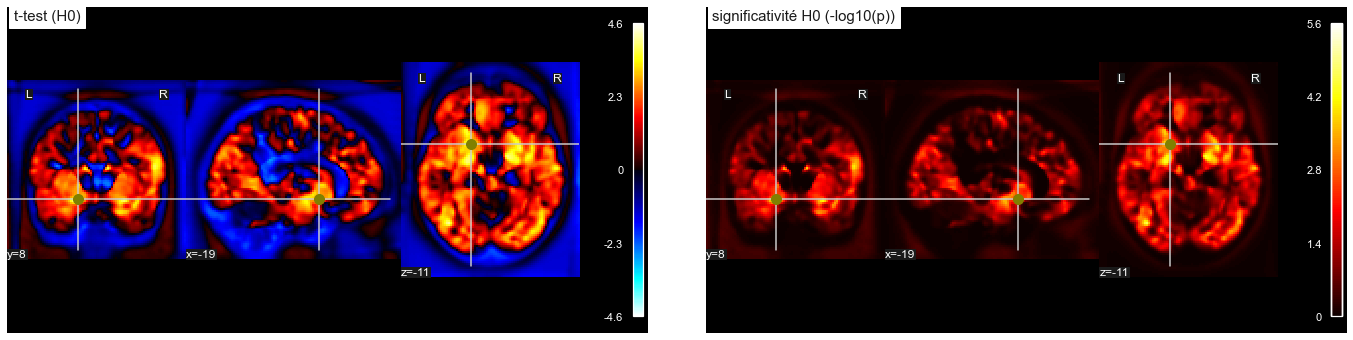

In [83]:
from numpy.random import seed
from numpy.random import shuffle
# seed random number generator
seed(1)
design_rand_df = df[["subject_label", "age"]].replace(['femelle', 'male'], value=[0, 1])
design_rand_matrix = make_second_level_design_matrix(
    subject_label,
    design_df
    )
shuffle(design_rand_matrix["age"].to_numpy())

second_level_model_rand = SecondLevelModel(smoothing_fwhm=5.0)
second_level_model_rand = second_level_model.fit(gray_matter_map_filenames,
                                            design_matrix=design_rand_matrix)

z_score_rand = second_level_model_rand.compute_contrast(second_level_contrast="age", output_type="z_score")
p_value_rand = second_level_model_rand.compute_contrast(second_level_contrast="age", output_type="p_value")
neg_log_pval_rand = math_img("-np.log10(np.minimum(1, img))", img=p_value_rand)

# On génère la Figure
from nilearn import plotting
import seaborn as sns
fig = plt.figure(figsize=(24, 6))

ax = plt.subplot2grid((1, 4), (0, 0), colspan=2)
roi_img = plotting.plot_stat_map(
    z_score_rand, bg_img=gray_matter_map_filenames[0], cut_coords=coords[1], figure=fig,
    axes=ax, display_mode='ortho', colorbar=True, title='t-test (H0)')
roi_img.add_markers([coords[1]], colors[1], 100)

ax = plt.subplot2grid((1, 4), (0, 2), colspan=2)
roi_img = plotting.plot_stat_map(
    neg_log_pval_rand, bg_img=gray_matter_map_filenames[0], cut_coords=coords[1], figure=fig,
    axes=ax, display_mode='ortho', colorbar=True, title='significativité H0 (-log10(p))')
roi_img.add_markers([coords[1]], colors[1], 100)



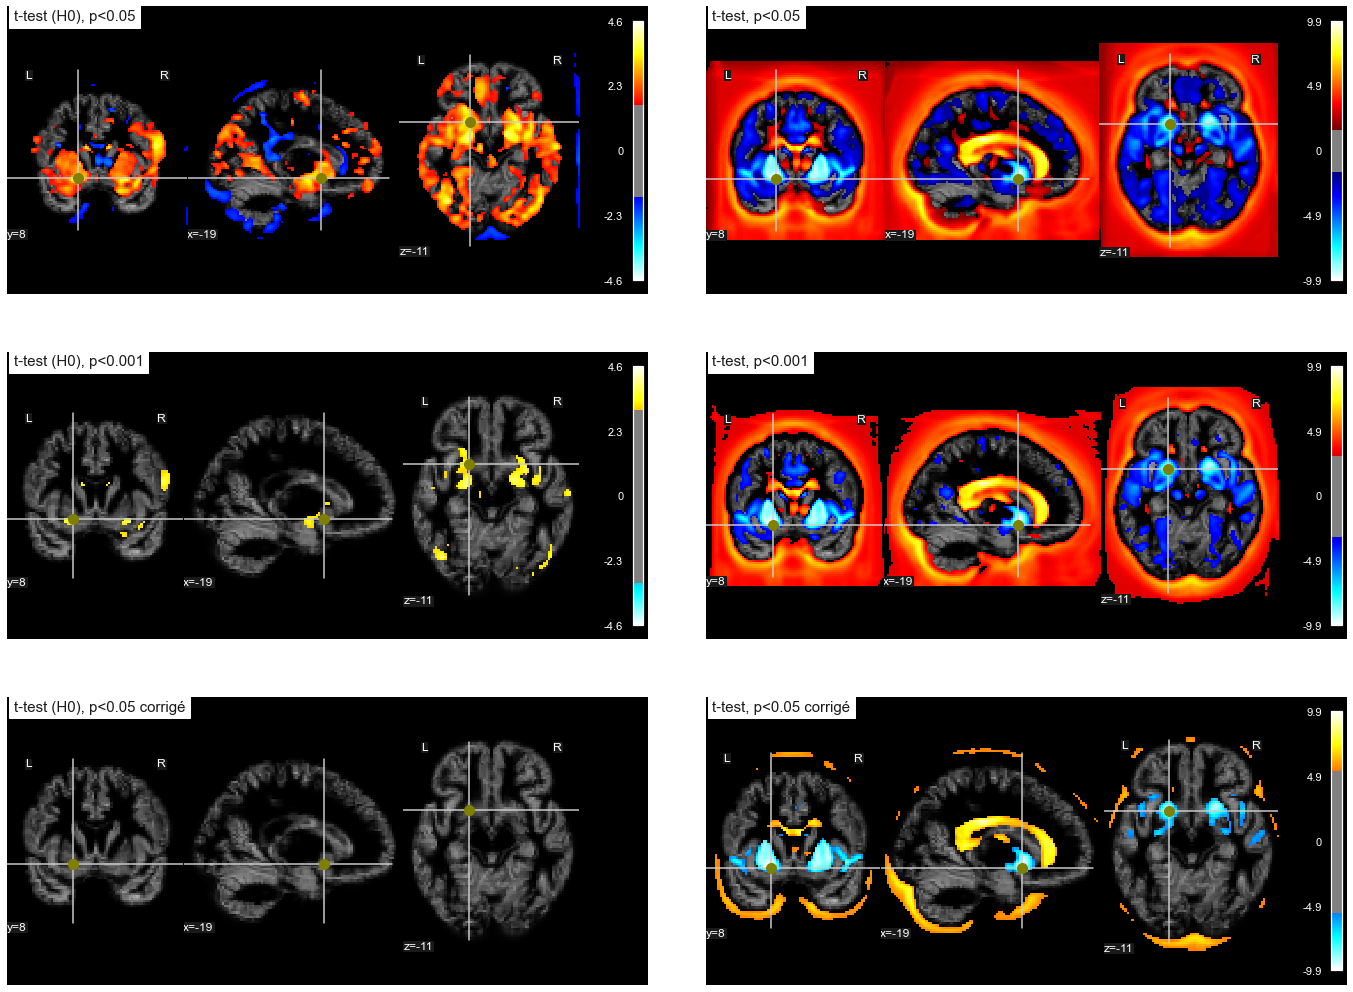

In [89]:
from nilearn.glm import threshold_stats_img
from scipy.stats import norm
p_val = 0.001
p001_uncorrected = norm.isf(p_val)
p_val = 0.05
p05_uncorrected = norm.isf(p_val)

# On génère la Figure
from nilearn import plotting
import seaborn as sns
fig = plt.figure(figsize=(24, 18))

ax = plt.subplot2grid((3, 4), (0, 2), colspan=2)
roi_img = plotting.plot_stat_map(
    z_score, threshold=p05_uncorrected, bg_img=gray_matter_map_filenames[0], cut_coords=coords[1], figure=fig,
    axes=ax, display_mode='ortho', colorbar=True, title='t-test, p<0.05')
roi_img.add_markers([coords[1]], colors[1], 100)

ax = plt.subplot2grid((3, 4), (1, 2), colspan=2)
roi_img = plotting.plot_stat_map(
    z_score, threshold=p001_uncorrected, bg_img=gray_matter_map_filenames[0], cut_coords=coords[1], figure=fig,
    axes=ax, display_mode='ortho', colorbar=True, title='t-test, p<0.001')
roi_img.add_markers([coords[1]], colors[1], 100)

ax = plt.subplot2grid((3, 4), (2, 2), colspan=2)
thresholded_map, threshold = threshold_stats_img(
    z_score, alpha=.05, height_control='bonferroni')
roi_img = plotting.plot_stat_map(
    z_score, threshold=threshold, bg_img=gray_matter_map_filenames[0], cut_coords=coords[1], figure=fig,
    axes=ax, display_mode='ortho', colorbar=True, title='t-test, p<0.05 corrigé')
roi_img.add_markers([coords[1]], colors[1], 100)

ax = plt.subplot2grid((3, 4), (0, 0), colspan=2)
roi_img = plotting.plot_stat_map(
    z_score_rand, threshold=p05_uncorrected, bg_img=gray_matter_map_filenames[0], cut_coords=coords[1], figure=fig,
    axes=ax, display_mode='ortho', colorbar=True, title='t-test (H0), p<0.05')
roi_img.add_markers([coords[1]], colors[1], 100)

ax = plt.subplot2grid((3, 4), (1, 0), colspan=2)
roi_img = plotting.plot_stat_map(
    z_score_rand, threshold=p001_uncorrected, bg_img=gray_matter_map_filenames[0], cut_coords=coords[1], figure=fig,
    axes=ax, display_mode='ortho', colorbar=True, title='t-test (H0), p<0.001')
roi_img.add_markers([coords[1]], colors[1], 100)

ax = plt.subplot2grid((3, 4), (2, 0), colspan=2)
thresholded_map_rand, threshold_rand = threshold_stats_img(
    z_score_rand, alpha=.05, height_control='bonferroni')
roi_img = plotting.plot_stat_map(
    z_score_rand, threshold=threshold_rand, bg_img=gray_matter_map_filenames[0], cut_coords=coords[1], figure=fig,
    axes=ax, display_mode='ortho', colorbar=True, title='t-test (H0), p<0.05 corrigé')
roi_img.add_markers([coords[1]], colors[1], 100)
